In [6]:
import os
sys.path.append(r'C:\Users\Hp\Desktop\ml labs\timeseires')

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from timeseires.callbacks.TrainingMonitor import TrainingMonitor
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [8]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [9]:
def create_lstm():
    input_data = Input(shape=(time_steps, num_features))
    lstm_layer1 = LSTM(8, return_sequences=True)(input_data)
    lstm_layer2 = LSTM(20)(lstm_layer1)
    x = Flatten()(lstm_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [10]:
model1 = create_lstm()
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 21)]          0         
                                                                 
 lstm (LSTM)                 (None, 24, 8)             960       
                                                                 
 lstm_1 (LSTM)               (None, 20)                2320      
                                                                 
 flatten (Flatten)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 3,301
Trainable params: 3,301
Non-trainable params: 0
_________________________________________________________________


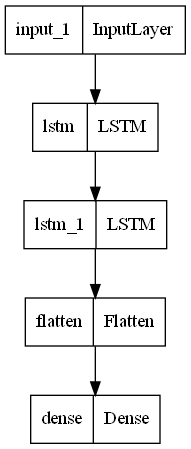

In [11]:
tensorflow.keras.utils.plot_model(model1 )

In [12]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 10\\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 10'
FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [13]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]

In [14]:
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model =create_lstm()
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] compiling model...


In [16]:
import os
path_dataset =r'C:\Users\Hp\Desktop\ml labs\last labs\AEP_hourly'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

((84907, 21), (24259, 21), (12130, 21))

In [17]:
time_steps=24
num_features=21

In [18]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 4.2978386878967285 sec


In [19]:
epochs = 60
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,verbose = verbose)

Epoch 1/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0377 - mae: 0.0377 - mape: 156.0357
Epoch 1: val_loss improved from inf to 0.01840, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E1-cp-0001-loss0.02.h5
2653/2653 [==============================] - 185s 51ms/step - loss: 0.0377 - mae: 0.0377 - mape: 156.0357 - val_loss: 0.0184 - val_mae: 0.0184 - val_mape: 7.6931
Epoch 2/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0175 - mae: 0.0175 - mape: 143.2400
Epoch 2: val_loss improved from 0.01840 to 0.01567, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E1-cp-0002-loss0.02.h5
2653/2653 [==============================] - 119s 45ms/step - loss: 0.0175 - mae: 0.0175 - mape: 143.2400 - val_loss: 0.0157 - val_mae: 0.0157 - val_mape: 7.1827
Epoch 3/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0128 - mae: 0.0128 - mape: 241.1273
Epoch 3: val_loss improved from 0.01567 to 0.01048, saving model to C:\Users\H

Epoch 24/60
2652/2653 [============================>.] - ETA: 0s - loss: 0.0068 - mae: 0.0068 - mape: 48.4861
Epoch 24: val_loss improved from 0.00647 to 0.00634, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E1-cp-0024-loss0.01.h5
2653/2653 [==============================] - 128s 48ms/step - loss: 0.0068 - mae: 0.0068 - mape: 48.4764 - val_loss: 0.0063 - val_mae: 0.0063 - val_mape: 2.6841
Epoch 25/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0067 - mape: 18.2926
Epoch 25: val_loss did not improve from 0.00634
2653/2653 [==============================] - 129s 49ms/step - loss: 0.0067 - mae: 0.0067 - mape: 18.2926 - val_loss: 0.0069 - val_mae: 0.0069 - val_mape: 3.1034
Epoch 26/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0067 - mae: 0.0067 - mape: 38.0945
Epoch 26: val_loss did not improve from 0.00634
2653/2653 [==============================] - 1490s 562ms/step - loss: 0.0067 - mae: 0.0067 - mape: 38.0945 - val_lo

2651/2653 [============================>.] - ETA: 0s - loss: 0.0063 - mae: 0.0063 - mape: 13.2496
Epoch 48: val_loss did not improve from 0.00614
2653/2653 [==============================] - 62s 24ms/step - loss: 0.0063 - mae: 0.0063 - mape: 13.2430 - val_loss: 0.0067 - val_mae: 0.0067 - val_mape: 2.7510
Epoch 49/60
2653/2653 [==============================] - ETA: 0s - loss: 0.0063 - mae: 0.0063 - mape: 87.3179
Epoch 49: val_loss did not improve from 0.00614
2653/2653 [==============================] - 65s 24ms/step - loss: 0.0063 - mae: 0.0063 - mape: 87.3179 - val_loss: 0.0062 - val_mae: 0.0062 - val_mape: 2.6636
Epoch 50/60
2651/2653 [============================>.] - ETA: 0s - loss: 0.0062 - mae: 0.0062 - mape: 61.6302
Epoch 50: val_loss did not improve from 0.00614
2653/2653 [==============================] - 63s 24ms/step - loss: 0.0062 - mae: 0.0062 - mape: 61.5951 - val_loss: 0.0065 - val_mae: 0.0065 - val_mape: 2.6971
Epoch 51/60
2653/2653 [==============================] - E

In [20]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E1-cp-0033-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 5s 8ms/step
Mean Absolute Error (MAE): 104.7
Median Absolute Error (MedAE): 80.87
Mean Squared Error (MSE): 19519.79
Root Mean Squared Error (RMSE): 139.71
Mean Absolute Percentage Error (MAPE): 0.71 %
Median Absolute Percentage Error (MDAPE): 0.56 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)


In [21]:
checkpoints = r'C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model=r'C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E1-cp-0033-loss0.01.h5'
start_epoch= 34

In [22]:
# construct the callback to save only the *best* model to disk
# based on the validation loss
EpochCheckpoint1 = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint1,TrainingMonitor1]
# if there is no specific model checkpoint supplied, then initialize
# the network and compile the model
if model is None:
    print("[INFO] compiling model...")
    model = PC.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])
# otherwise, load the checkpoint from disk
else:
    print("[INFO] loading {}...".format(model))
    model = load_model(model)

    # update the learning rate
    print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
    K.set_value(model.optimizer.lr, 1e-4)
    print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

[INFO] loading C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E1-cp-0033-loss0.01.h5...
[INFO] old learning rate: 0.0010000000474974513
[INFO] new learning rate: 9.999999747378752e-05


In [23]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2653/2653 [==============================] - ETA: 0s - loss: 0.0058 - mae: 0.0058 - mape: 62.7329
Epoch 1: val_loss improved from inf to 0.00590, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E2-cp-0001-loss0.01.h5
2653/2653 [==============================] - 71s 25ms/step - loss: 0.0058 - mae: 0.0058 - mape: 62.7329 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4961
Epoch 2/10
2652/2653 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0057 - mape: 49.5451
Epoch 2: val_loss improved from 0.00590 to 0.00589, saving model to C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E2-cp-0002-loss0.01.h5
2653/2653 [==============================] - 64s 24ms/step - loss: 0.0057 - mae: 0.0057 - mape: 49.5350 - val_loss: 0.0059 - val_mae: 0.0059 - val_mape: 2.4924
Epoch 3/10
2652/2653 [============================>.] - ETA: 0s - loss: 0.0057 - mae: 0.0057 - mape: 86.6419
Epoch 3: val_loss did not improve from 0.00589
2653/2653 [===========================

In [24]:

model = load_model(r'C:\Users\Hp\Desktop\ml labs\last labs\lab 10\E2-cp-0004-loss0.01.h5')

y_pred_scaled   = model.predict(test_X)
y_pred          = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)
# Mean Absolute Error (MAE)
MAE = np.mean(abs(y_pred - y_test_unscaled)) 
print('Mean Absolute Error (MAE): ' + str(np.round(MAE, 2)))

# Median Absolute Error (MedAE)
MEDAE = np.median(abs(y_pred - y_test_unscaled))
print('Median Absolute Error (MedAE): ' + str(np.round(MEDAE, 2)))

# Mean Squared Error (MSE)
MSE = np.square(np.subtract(y_pred, y_test_unscaled)).mean()
print('Mean Squared Error (MSE): ' + str(np.round(MSE, 2)))

# Root Mean Squarred Error (RMSE) 
RMSE = np.sqrt(np.mean(np.square(y_pred - y_test_unscaled)))
print('Root Mean Squared Error (RMSE): ' + str(np.round(RMSE, 2)))

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Mean Absolute Percentage Error (MAPE): ' + str(np.round(MAPE, 2)) + ' %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print('Median Absolute Percentage Error (MDAPE): ' + str(np.round(MDAPE, 2)) + ' %')

print('\n\ny_test_unscaled.shape= ',y_test_unscaled.shape)
print('y_pred.shape= ',y_pred.shape)

379/379 [==============================] - 4s 7ms/step
Mean Absolute Error (MAE): 98.79
Median Absolute Error (MedAE): 76.7
Mean Squared Error (MSE): 17537.31
Root Mean Squared Error (RMSE): 132.43
Mean Absolute Percentage Error (MAPE): 0.67 %
Median Absolute Percentage Error (MDAPE): 0.53 %


y_test_unscaled.shape=  (12105, 1)
y_pred.shape=  (12105, 1)
